In [2]:
# **Setup Paths - Works for both Local and Colab**
import os
import subprocess
from pathlib import Path

# Detect if running in Colab
try:
    import google.colab
    IN_COLAB = True
    print("✓ Detected: Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("✓ Detected: Running locally")

if IN_COLAB:
    # Running in Colab - Clone repository if not already present
    REPO_URL = "https://github.com/dhayarajas/AmazonLLM.git"
    REPO_NAME = "AmazonLLM"
    
    # Check if Dataset directory already exists (repository might be partially cloned)
    dataset_exists = Path(REPO_NAME).exists() and (Path(REPO_NAME) / 'Dataset').exists()
    repo_exists = Path(REPO_NAME).exists()
    
    if dataset_exists:
        print(f"✓ Repository and Dataset directory already exist at {REPO_NAME}/")
        print("  Skipping clone. If you need to update, run manually: !git -C AmazonLLM pull")
    elif repo_exists:
        print(f"⚠️  Repository directory exists but Dataset/ not found.")
        print(f"   This might be a partial clone. Checking...")
        # Check if it's a valid git repo
        if (Path(REPO_NAME) / '.git').exists():
            print(f"   Valid git repository found. Trying to pull updates...")
            try:
                subprocess.run(['git', '-C', REPO_NAME, 'pull'], 
                             capture_output=True, timeout=300)
                print(f"   ✓ Repository updated")
            except:
                print(f"   ⚠️  Could not update. You may need to manually clone.")
        else:
            print(f"   Not a valid git repository. Will attempt clone...")
    
    if not dataset_exists:
        print(f"📥 Cloning repository from {REPO_URL}...")
        print("⚠️  Note: Repository contains large files. This may take 15-30 minutes.")
        print("💡 Using shallow clone (--depth 1) to reduce download size...")
        print("💡 TIP: If this times out, use manual clone: !git clone --depth 1 {REPO_URL}")
        print("   Manual clone shows progress and has no timeout limit.")
        
        # Try shallow clone first (faster, smaller download)
        try:
            print("🔄 Attempting shallow clone (depth=1)...")
            print("⏱️  This may take 15-20 minutes for large repositories...")
            result = subprocess.run(
                ['git', 'clone', '--depth', '1', REPO_URL],
                capture_output=True,
                text=True,
                timeout=1800  # 30 minutes timeout for large files
            )
            if result.returncode == 0:
                print(f"✓ Successfully cloned repository (shallow) to {REPO_NAME}/")
            else:
                print(f"⚠ Shallow clone failed. Trying full clone...")
                print(f"Error: {result.stderr[:200]}...")  # Show first 200 chars
                raise Exception("Shallow clone failed")
        except subprocess.TimeoutExpired:
            print("⏱️  Clone timed out (took longer than 30 minutes)")
            print("\n💡 RECOMMENDED: Use manual git clone command instead:")
            print(f"   Run this in a new cell: !git clone {REPO_URL}")
            print("   This will show progress and won't timeout.")
            print("\n   Or use shallow clone manually:")
            print(f"   !git clone --depth 1 {REPO_URL}")
            print("\n   After cloning, re-run this cell to continue.")
            # Don't raise - allow user to manually clone
            print("\n⚠️  Please clone manually and re-run this cell.")
            raise
        except Exception as e:
            # If shallow clone fails, try full clone
            print(f"\n🔄 Shallow clone failed: {e}")
            print("🔄 Attempting full clone (this will take longer)...")
            try:
                print("⏱️  Full clone may take 30-60 minutes for large repositories...")
                result = subprocess.run(
                    ['git', 'clone', REPO_URL],
                    capture_output=True,
                    text=True,
                    timeout=3600  # 60 minutes for full clone
                )
                if result.returncode == 0:
                    print(f"✓ Successfully cloned repository (full) to {REPO_NAME}/")
                else:
                    print(f"⚠ Full clone also failed.")
                    print(f"Error: {result.stderr[:200]}...")
                    raise Exception("Full clone failed")
            except subprocess.TimeoutExpired:
                print("⏱️  Full clone also timed out (took longer than 60 minutes)")
                print("\n💡 RECOMMENDED: Use manual git clone command instead:")
                print(f"   Run this in a new cell: !git clone {REPO_URL}")
                print("   This will show progress and won't timeout.")
                print("\n   After cloning, re-run this cell to continue.")
                raise
            except Exception as e2:
                print(f"⚠ Full clone failed: {e2}")
                print(f"\n💡 Please run this command manually in a new cell:")
                print(f"   !git clone {REPO_URL}")
                print(f"   Or for faster clone: !git clone --depth 1 {REPO_URL}")
                print(f"Then re-run this cell.")
                raise
    if repo_exists and not dataset_exists:
        # Repository exists but Dataset missing - try to update
        print(f"🔄 Repository exists but Dataset missing. Attempting to update...")
        try:
            result = subprocess.run(['git', '-C', REPO_NAME, 'pull'], 
                                 capture_output=True, timeout=300, text=True)
            if result.returncode == 0:
                print(f"✓ Repository updated successfully")
            else:
                print(f"⚠️  Update failed. You may need to manually clone.")
        except subprocess.TimeoutExpired:
            print(f"⏱️  Update timed out. Please run manually: !git -C AmazonLLM pull")
        except:
            print(f"⚠️  Could not update repository. Continuing with existing files...")
    
    # Get absolute path before changing directory
    repo_path = Path(REPO_NAME).resolve()
    
    # Check if we're already in a nested directory (e.g., /content/AmazonLLM/AmazonLLM)
    # If so, go up one level to the actual repo root
    current_dir = Path.cwd()
    if current_dir.name == REPO_NAME and (current_dir.parent / REPO_NAME).exists():
        # We're in a nested directory, go to parent
        os.chdir(current_dir.parent)
        print(f"⚠️  Detected nested directory. Changed to: {Path.cwd()}")
    
    # Change to repository directory
    if repo_path.exists():
        os.chdir(repo_path)
    else:
        # Try relative path
        if Path(REPO_NAME).exists():
            os.chdir(Path(REPO_NAME))
        else:
            print(f"⚠️  Repository directory not found at: {repo_path}")
            print(f"   Current directory: {Path.cwd()}")
            print(f"   Looking for: {REPO_NAME}")
    
    # Update BASE_DIR to current working directory (absolute path)
    BASE_DIR = Path.cwd()
    print(f"✓ Using Colab repository directory: {BASE_DIR}")
    
    # Install and pull Git LFS files (for large files like merged_df.csv, amazon_products.csv)
    print(f"\n📦 Checking for Git LFS files...")
    try:
        # Check if git-lfs is installed
        lfs_check = subprocess.run(['git', 'lfs', 'version'], 
                                   capture_output=True, text=True, timeout=10)
        if lfs_check.returncode != 0:
            print("   Installing Git LFS...")
            subprocess.run(['git', 'lfs', 'install'], 
                          capture_output=True, text=True, timeout=30)
            print("   ✓ Git LFS installed")
        else:
            print("   ✓ Git LFS already installed")
        
        # Pull LFS files
        print("   Pulling Git LFS files (this may take a few minutes for large files)...")
        lfs_pull = subprocess.run(['git', 'lfs', 'pull'], 
                                 capture_output=True, text=True, timeout=600)  # 10 min timeout
        if lfs_pull.returncode == 0:
            print("   ✓ Git LFS files pulled successfully")
        else:
            # Check for specific LFS budget error
            error_msg = lfs_pull.stderr if lfs_pull.stderr else ""
            if "LFS budget" in error_msg or "exceeded" in error_msg.lower():
                print(f"\n   ⚠️  Git LFS Budget Exceeded")
                print(f"   The repository has exceeded its Git LFS bandwidth/storage limit.")
                print(f"\n   🔄 Attempting to download files directly from GitHub...")
                
                # Try to download files directly from GitHub raw URLs
                import urllib.request
                import urllib.error
                
                dataset_dir = BASE_DIR / 'Dataset'
                dataset_dir.mkdir(exist_ok=True)
                
                # Files to download from GitHub
                github_base = "https://raw.githubusercontent.com/dhayarajas/AmazonLLM/main/Dataset"
                files_to_download = [
                    'amazon_categories.csv',
                    'amazon_products.csv',
                    'merged_df.csv',
                    'new_LLM_data.csv'
                ]
                
                downloaded = []
                failed = []
                
                for filename in files_to_download:
                    filepath = dataset_dir / filename
                    if filepath.exists():
                        print(f"   ✓ {filename} already exists, skipping")
                        downloaded.append(filename)
                        continue
                    
                    url = f"{github_base}/{filename}"
                    try:
                        print(f"   📥 Downloading {filename}...")
                        urllib.request.urlretrieve(url, filepath)
                        size_mb = filepath.stat().st_size / (1024 * 1024)
                        print(f"   ✓ Downloaded {filename} ({size_mb:.2f} MB)")
                        downloaded.append(filename)
                    except urllib.error.HTTPError as e:
                        if e.code == 404:
                            print(f"   ⚠️  {filename} not found at GitHub (may be LFS-only)")
                        else:
                            print(f"   ✗ Failed to download {filename}: HTTP {e.code}")
                        failed.append(filename)
                    except Exception as e:
                        print(f"   ✗ Failed to download {filename}: {e}")
                        failed.append(filename)
                
                if downloaded:
                    print(f"\n   ✓ Successfully downloaded {len(downloaded)} file(s)")
                if failed:
                    print(f"\n   ⚠️  Could not download {len(failed)} file(s) from GitHub")
                    print(f"   💡 Alternative solutions:")
                    print(f"   1. Generate merged_df.csv from source: The notebook can automatically")
                    print(f"      generate merged_df.csv from amazon_categories.csv and amazon_products.csv")
                    print(f"      if those source files are available.")
                    print(f"   2. Manual upload: Upload files directly to Colab:")
                    print(f"      - Go to Files → Upload to session storage")
                    print(f"      - Upload missing files to Dataset/ folder")
                    print(f"   3. Use Google Drive: Mount Google Drive and copy files from there")
                    print(f"   4. Direct download: Visit https://github.com/dhayarajas/AmazonLLM/tree/main/Dataset")
                    print(f"      and download files manually")
                print(f"\n   The notebook will continue and try to generate files from source if possible.")
            else:
                print(f"   ⚠️  Git LFS pull had issues (this is okay if files are already downloaded)")
                if error_msg:
                    print(f"   Error: {error_msg[:200]}")
    except subprocess.TimeoutExpired:
        print("   ⏱️  Git LFS pull timed out. Large files may need manual download.")
        print("   You can manually run: !git lfs pull")
        print("   Or upload files directly to Colab Files → Upload")
    except Exception as e:
        print(f"   ⚠️  Could not pull Git LFS files: {e}")
        print("   This is okay if files are already present or not using LFS.")
        print("   The notebook can generate merged_df.csv from source files if available.")
    
else:
    # Running locally - Use local path
    # Option 1: Manually set your project directory
    BASE_DIR = Path('/Users/dhaya/PhD/Learnings/Amazon-LLM')
    
    # Option 2: Auto-detect (uncomment if manual path doesn't work)
    """
    BASE_DIR = None
    possible_paths = [
        Path('/Users/dhaya/PhD/Learnings/Amazon-LLM'),
        Path.cwd(),
        Path.cwd().parent,
        Path.home() / 'PhD' / 'Learnings' / 'Amazon-LLM',
    ]
    
    for path in possible_paths:
        if (path / 'Dataset').exists() and (path / 'Dataset' / 'merged_df.csv').exists():
            BASE_DIR = path
            print(f"✓ Found Dataset directory at: {BASE_DIR}")
            break
    
    if BASE_DIR is None:
        BASE_DIR = Path.cwd()
        print(f"⚠ Using current directory: {BASE_DIR}")
    """
    
    os.chdir(BASE_DIR)
    print(f"✓ Using local directory: {BASE_DIR}")

# Verify setup (BASE_DIR is already set and we've changed to it)
# Ensure BASE_DIR is always absolute
BASE_DIR = Path(BASE_DIR).resolve() if not Path(BASE_DIR).is_absolute() else Path(BASE_DIR)
print(f"\nBase directory: {BASE_DIR}")
print(f"Base directory (absolute): {BASE_DIR.resolve()}")
print(f"Current working directory: {os.getcwd()}")
print(f"Dataset directory exists: {(BASE_DIR / 'Dataset').exists()}")
print(f"Results directory exists: {(BASE_DIR / 'results').exists()}")

# Verify key files exist
if (BASE_DIR / 'Dataset').exists():
    dataset_files = list((BASE_DIR / 'Dataset').glob('*.csv'))
    print(f"\nFound {len(dataset_files)} CSV files in Dataset/:")
    for f in dataset_files[:5]:
        print(f"  - {f.name}")
    if len(dataset_files) > 5:
        print(f"  ... and {len(dataset_files) - 5} more")

print(f"\nCurrent working directory: {os.getcwd()}")

✓ Detected: Running in Google Colab
✓ Repository and Dataset directory already exist at AmazonLLM/
  Skipping clone. If you need to update, run manually: !git -C AmazonLLM pull
✓ Using Colab repository directory: /content/AmazonLLM

Base directory: /content/AmazonLLM
Base directory (absolute): /content/AmazonLLM
Current working directory: /content/AmazonLLM
Dataset directory exists: True
Results directory exists: True

Found 3 CSV files in Dataset/:
  - amazon_categories.csv
  - merged_df.csv
  - new_LLM_data.csv

Current working directory: /content/AmazonLLM


# **Verify Local File Structure**

In [3]:
# List files in current directory
import os
from pathlib import Path

files = [f for f in os.listdir('.') if os.path.isfile(f)]
dirs = [d for d in os.listdir('.') if os.path.isdir(d)]

print("Files in current directory:")
for f in sorted(files):
    print(f"  {f}")

print("\nDirectories in current directory:")
for d in sorted(dirs):
    print(f"  {d}/")

Files in current directory:
   Paper 14.12.2024.docx
   Paper 14.12.2024.pdf
  .gitattributes
  .gitignore
  Algorithm.pages
  Amazon review.docx
  Novelty_Code_PseudoCode_Proposed_Advantages.docx
  Proposed_SVD_28_11_24.ipynb
  Rayleigh_SVD.pdf
  Rayleigh_eigenproblems.pdf
  Traditional_SVD_28_11_24.ipynb
  _Flow_Up_17-09-24.pptx
  ~$azon review.docx

Directories in current directory:
  .git/
  AmazonLLM/
  Dataset/
  media/
  results/
  wandb/


In [4]:
# Check if required directories exist
required_dirs = ['Dataset', 'results']
for dir_name in required_dirs:
    if os.path.exists(dir_name):
        print(f"✓ {dir_name}/ exists")
        if dir_name == 'Dataset':
            dataset_files = os.listdir(dir_name)
            print(f"  Files: {', '.join(dataset_files[:5])}{'...' if len(dataset_files) > 5 else ''}")
    else:
        print(f"✗ {dir_name}/ does not exist - please create it")

✓ Dataset/ exists
  Files: amazon_categories.csv, merged_df.csv, new_LLM_data.csv
✓ results/ exists


# **Install packages (if needed)**
# Uncomment the line below if you need to install packages
# Run this only if packages are not already installed

In [5]:
# Uncomment to install packages if needed
# import subprocess
# import sys
# 
# packages = ['transformers', 'pandas', 'scikit-learn', 'torch', 'datasets', 'accelerate']
# for package in packages:
#     subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '-U'])
# 
# print("Packages installed. Please restart kernel if needed.")

In [6]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import torch
from transformers import pipeline
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer, AutoModelForSeq2SeqLM
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# BASE_DIR is already set in the first cell
# Just verify we're in the right place
print(f"Working directory: {os.getcwd()}")
print(f"BASE_DIR: {BASE_DIR}")


Working directory: /content/AmazonLLM
BASE_DIR: /content/AmazonLLM


# **Load the dataset**

In [7]:
# import kagglehub
# path = kagglehub.dataset_download("asaniczka/amazon-products-dataset-2023-1-4m-products")
# print("Path to dataset files:", path)

# amazon_products_file_path = os.path.join(path, 'amazon_products.csv')
# amazon_categories_file_path  = os.path.join(path, 'amazon_categories.csv')

# df_products = pd.read_csv(amazon_products_file_path)
# df_categories = pd.read_csv(amazon_categories_file_path)

# df_products.to_csv('Dataset/amazon_products.csv', index=False)
# df_categories.to_csv('Dataset/amazon_categories.csv', index=False)

In [8]:
# df_products = pd.read_csv('Dataset/amazon_products.csv')
# df_products['stars'] = df_products['stars'].apply(lambda x: int(round(x)))
# df_categories = pd.read_csv('Dataset/amazon_categories.csv')

In [9]:
def display_styled_dataframe(df):
  return df.style.set_properties(**{'text-align': 'left'})

In [10]:
# display_styled_dataframe(df_products.head())

In [11]:
# display_styled_dataframe(df_categories.head())

In [12]:
# Verify dataset files exist
dataset_path = Path('Dataset')
if dataset_path.exists():
    print("Dataset directory contents:")
    for file in sorted(dataset_path.iterdir()):
        if file.is_file():
            size = file.stat().st_size / (1024 * 1024)  # Size in MB
            print(f"  {file.name} ({size:.2f} MB)")
else:
    print("Dataset directory not found!")

Dataset directory contents:
  amazon_categories.csv (0.01 MB)
  merged_df.csv (273.38 MB)
  new_LLM_data.csv (589.87 MB)


Merge the dataset

In [13]:
# df_categories.rename(columns={'id':'category_id'}, inplace=True)
# merged_df = pd.merge(df_categories, df_products, on=['category_id'], how='inner')
# merged_df.to_csv('Dataset/merged_df.csv', index=False)

# Load merged dataset from local file
# Ensure BASE_DIR is absolute
BASE_DIR = Path(BASE_DIR).resolve() if not Path(BASE_DIR).is_absolute() else Path(BASE_DIR)

merged_df_path = BASE_DIR / 'Dataset' / 'merged_df.csv'

# Try multiple paths (absolute and relative)
alt_paths = [
    merged_df_path,  # Primary path
    Path('Dataset/merged_df.csv').resolve(),  # Relative from current dir
    BASE_DIR / 'merged_df.csv',  # In BASE_DIR root
    Path.cwd() / 'Dataset' / 'merged_df.csv',  # From current working directory
    Path.cwd().parent / 'Dataset' / 'merged_df.csv',  # One level up (fixes nested dir issue)
    Path('/content/AmazonLLM/Dataset/merged_df.csv'),  # Colab absolute path
    Path('/content') / 'AmazonLLM' / 'Dataset' / 'merged_df.csv',  # Colab absolute (alternative)
]

found = False
for alt_path in alt_paths:
    try:
        alt_path = alt_path.resolve()  # Make absolute
        if alt_path.exists():
            merged_df = pd.read_csv(alt_path)
            print(f"✓ Loaded merged_df.csv from: {alt_path}")
            print(f"  {len(merged_df)} rows, {len(merged_df.columns)} columns")
            found = True
            break
    except (OSError, ValueError):
        continue  # Skip invalid paths

if not found:
    # Try to generate merged_df.csv from source files
    dataset_dir = BASE_DIR / 'Dataset'
    categories_path = dataset_dir / 'amazon_categories.csv'
    products_path = dataset_dir / 'amazon_products.csv'
    
            # Check if source files exist
            categories_exists = categories_path.exists()
            products_exists = products_path.exists()
            
            # If source files don't exist, try to download from Kaggle
            if not categories_exists or not products_exists:
                print(f"\n📥 Source files missing. Attempting to download from Kaggle...")
                print(f"   Dataset: Amazon Products Dataset 2023 (1.4M products)")
                print(f"   Source: https://www.kaggle.com/datasets/asaniczka/amazon-products-dataset-2023-1-4m-products")
                
                # Try to download using Kaggle API
                try:
                    import kaggle
                    from kaggle.api.kaggle_api_extended import KaggleApi
                    
                    # Initialize Kaggle API
                    api = KaggleApi()
                    api.authenticate()
                    
                    dataset_name = "asaniczka/amazon-products-dataset-2023-1-4m-products"
                    download_path = str(dataset_dir)
                    
                    print(f"   Downloading from Kaggle...")
                    print(f"   This may take several minutes for large files...")
                    
                    # Download the dataset
                    api.dataset_download_files(dataset_name, path=download_path, unzip=True)
                    
                    # Check what was downloaded
                    downloaded_files = list(dataset_dir.glob('*.csv'))
                    print(f"   ✓ Downloaded {len(downloaded_files)} CSV file(s)")
                    for f in downloaded_files:
                        size_mb = f.stat().st_size / (1024 * 1024)
                        print(f"     - {f.name} ({size_mb:.2f} MB)")
                    
                    # Update existence flags
                    categories_exists = categories_path.exists()
                    products_exists = products_path.exists()
                    
                except ImportError:
                    print(f"   ⚠️  Kaggle package not installed.")
                    print(f"   💡 To download from Kaggle, install and authenticate:")
                    print(f"      1. Install: !pip install kaggle")
                    print(f"      2. Get API token from: https://www.kaggle.com/settings")
                    print(f"      3. Upload kaggle.json to Colab or set environment variables")
                    print(f"      4. Or download manually from: https://www.kaggle.com/datasets/asaniczka/amazon-products-dataset-2023-1-4m-products")
                except Exception as e:
                    print(f"   ⚠️  Could not download from Kaggle: {e}")
                    print(f"   💡 Alternative options:")
                    print(f"      1. Manual download from: https://www.kaggle.com/datasets/asaniczka/amazon-products-dataset-2023-1-4m-products")
                    print(f"      2. Upload files directly to Colab: Files → Upload")
                    print(f"      3. Use Google Drive: Mount Drive and copy files")
            
            if categories_exists and products_exists:
        print(f"\n🔄 merged_df.csv not found, but source files exist.")
        print(f"   Generating merged_df.csv from amazon_categories.csv and amazon_products.csv...")
        print(f"   This may take a few minutes for large datasets...")
        
        try:
            # Load source files
            df_categories = pd.read_csv(categories_path)
            df_products = pd.read_csv(products_path)
            
            # Rename 'id' to 'category_id' in categories if needed
            if 'id' in df_categories.columns and 'category_id' not in df_categories.columns:
                df_categories.rename(columns={'id': 'category_id'}, inplace=True)
            
            # Merge datasets
            merged_df = pd.merge(df_categories, df_products, on=['category_id'], how='inner')
            
            # Save merged dataset
            merged_df.to_csv(merged_df_path, index=False)
            print(f"✓ Successfully generated merged_df.csv: {len(merged_df)} rows, {len(merged_df.columns)} columns")
            print(f"   Saved to: {merged_df_path}")
            found = True
        except Exception as e:
            print(f"✗ Error generating merged_df.csv: {e}")
            print(f"   Please check that both source files are valid CSV files.")
            raise
    else:
        # Source files missing - provide detailed error message
        print(f"✗ File not found. Checked the following paths:")
        for path in alt_paths:
            try:
                abs_path = path.resolve()
                exists = abs_path.exists()
                print(f"  {'✓' if exists else '✗'} {abs_path} {'(exists)' if exists else '(not found)'}")
            except:
                print(f"  ✗ {path} (invalid path)")
        
        print(f"\nCurrent working directory: {os.getcwd()}")
        print(f"BASE_DIR: {BASE_DIR}")
        print(f"BASE_DIR absolute: {Path(BASE_DIR).resolve()}")
        
        # Check if Dataset directory exists
        if dataset_dir.exists():
            print(f"\n✓ Dataset directory exists at: {dataset_dir}")
            files = list(dataset_dir.glob('*.csv'))
            print(f"  Found {len(files)} CSV files:")
            for f in files[:10]:
                print(f"    - {f.name}")
            
            # Check which source files are missing
            print(f"\n📋 Source file status:")
            print(f"  {'✓' if categories_exists else '✗'} amazon_categories.csv {'(found)' if categories_exists else '(missing)'}")
            print(f"  {'✓' if products_exists else '✗'} amazon_products.csv {'(found)' if products_exists else '(missing)'}")
            
            if not categories_exists or not products_exists:
                print(f"\n⚠️  Large files may be stored in Git LFS and not downloaded automatically.")
                print(f"   To download Git LFS files in Colab, run:")
                print(f"   !git lfs install")
                print(f"   !git lfs pull")
                print(f"   Or manually download the files from the repository.")
        else:
            print(f"\n✗ Dataset directory not found at: {dataset_dir}")
            # Check alternative locations
            for check_dir in [Path('Dataset'), Path.cwd() / 'Dataset', Path.cwd().parent / 'Dataset']:
                if check_dir.exists():
                    print(f"  Found Dataset directory at: {check_dir.resolve()}")
        
        print("\n💡 Suggestions:")
        print("   1. Ensure the repository was cloned successfully in Colab")
        print("   2. If files are in Git LFS, install and pull LFS files:")
        print("      !git lfs install")
        print("      !git lfs pull")
        print("   3. Check that amazon_categories.csv and amazon_products.csv exist in Dataset/")
        print("   4. If in Colab, files should be at: /content/AmazonLLM/Dataset/")
        
        if not found:
            raise FileNotFoundError(f"Dataset file not found. Checked {len(alt_paths)} different paths. Source files also missing or incomplete.")

✓ Loaded merged_df.csv from: /content/AmazonLLM/Dataset/merged_df.csv
  1020742 rows, 12 columns


In [14]:
merged_df.columns

Index(['category_id', 'category_name', 'asin', 'title', 'imgUrl', 'productURL',
       'stars', 'reviews', 'price', 'listPrice', 'isBestSeller',
       'boughtInLastMonth'],
      dtype='object')

# **EDA**

In [15]:
df = merged_df

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020742 entries, 0 to 1020741
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   category_id        1020742 non-null  int64  
 1   category_name      1020742 non-null  object 
 2   asin               1020741 non-null  object 
 3   title              1020740 non-null  object 
 4   imgUrl             1020741 non-null  object 
 5   productURL         1020741 non-null  object 
 6   stars              1020741 non-null  float64
 7   reviews            1020741 non-null  float64
 8   price              1020741 non-null  float64
 9   listPrice          1020741 non-null  float64
 10  isBestSeller       1020741 non-null  object 
 11  boughtInLastMonth  1020741 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 93.5+ MB


In [17]:
import collections

print(merged_df['category_name'].unique())

['Beading & Jewelry Making' 'Fabric Decorating'
 'Knitting & Crochet Supplies' 'Printmaking Supplies'
 'Scrapbooking & Stamping Supplies' 'Sewing Products'
 'Craft & Hobby Fabric' 'Needlework Supplies'
 'Arts, Crafts & Sewing Storage' 'Painting, Drawing & Art Supplies'
 'Craft Supplies & Materials' 'Gift Wrapping Supplies' 'Party Decorations'
 'Automotive Paint & Paint Supplies'
 'Heavy Duty & Commercial Vehicle Equipment' 'Automotive Tires & Wheels'
 'Automotive Tools & Equipment'
 'Automotive Performance Parts & Accessories' 'Car Care' 'Oils & Fluids'
 'Automotive Replacement Parts' 'Lights, Bulbs & Indicators'
 'Automotive Interior Accessories' 'Automotive Exterior Accessories'
 'Automotive Enthusiast Merchandise' 'Car Electronics & Accessories'
 'RV Parts & Accessories' 'Motorcycle & Powersports'
 'Baby Diapering Products' 'Baby & Toddler Feeding Supplies'
 'Pregnancy & Maternity Products' 'Child Safety Car Seats & Accessories'
 'Baby Safety Products' 'Toilet Training Products' 'Ba

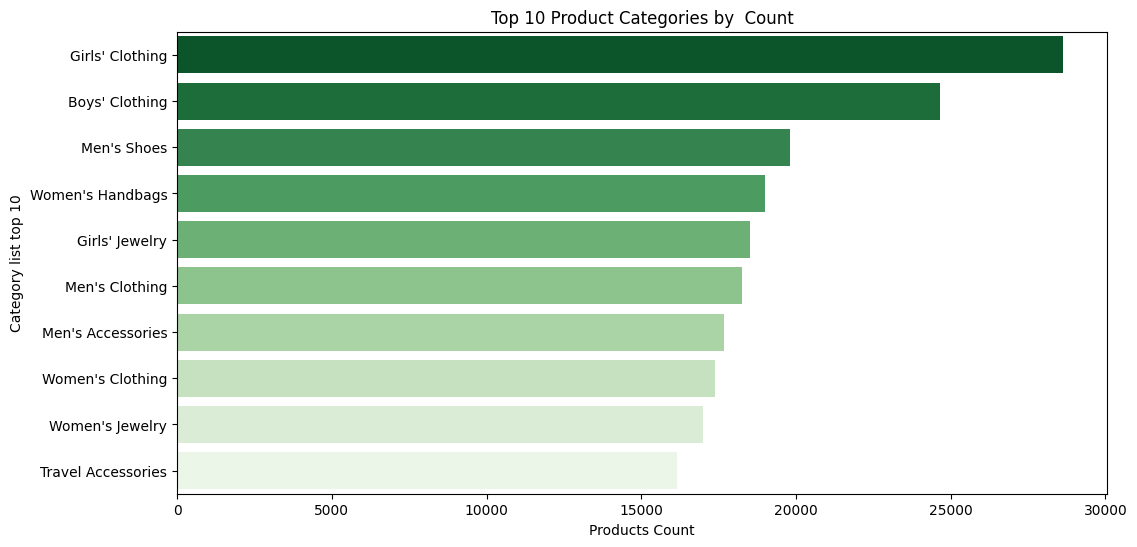

In [18]:
#Top 10 product categories

import seaborn as sns
import matplotlib.pyplot as plt
df = merged_df
custom_palette = sns.color_palette("Greens_r", n_colors=10)

plt.figure(figsize=(12, 6))
top_categories = df['category_name'].value_counts().nlargest(10)
sns.barplot(x=top_categories.values, y=top_categories.index, palette=custom_palette)
plt.title('Top 10 Product Categories by  Count')
plt.xlabel('Products Count')
plt.ylabel('Category list top 10')
plt.show()

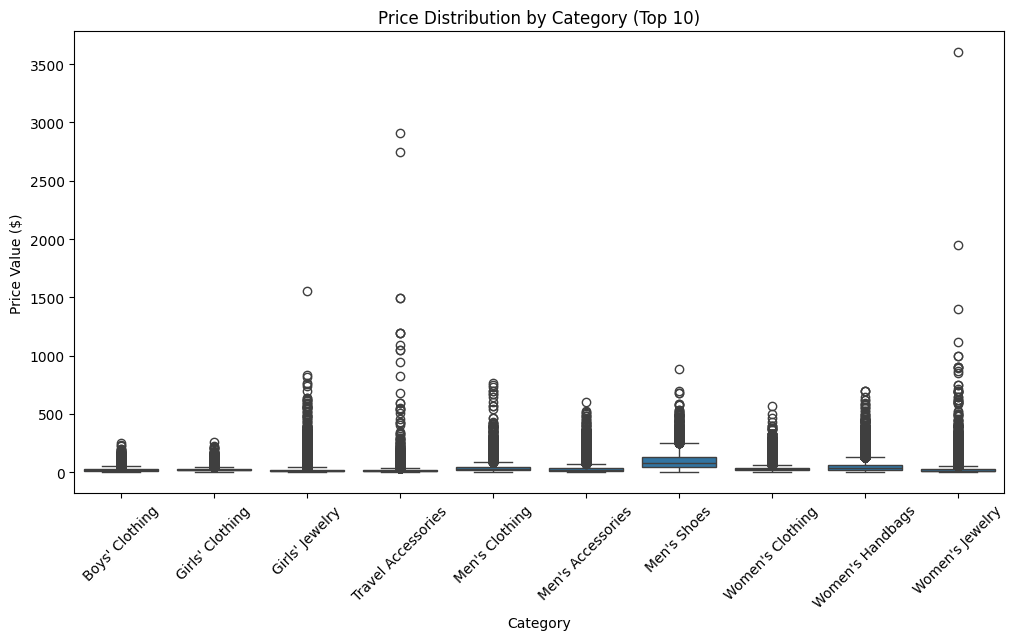

In [19]:
# Price Distribution by Category
plt.figure(figsize=(12, 6))
top_10_categories = df['category_name'].value_counts().nlargest(10).index
sns.boxplot(x='category_name', y='price', data=df[df['category_name'].isin(top_10_categories)])
plt.title('Price Distribution by Category (Top 10)')
plt.xlabel('Category')
plt.ylabel('Price Value ($)')
plt.xticks(rotation=45)
plt.show()

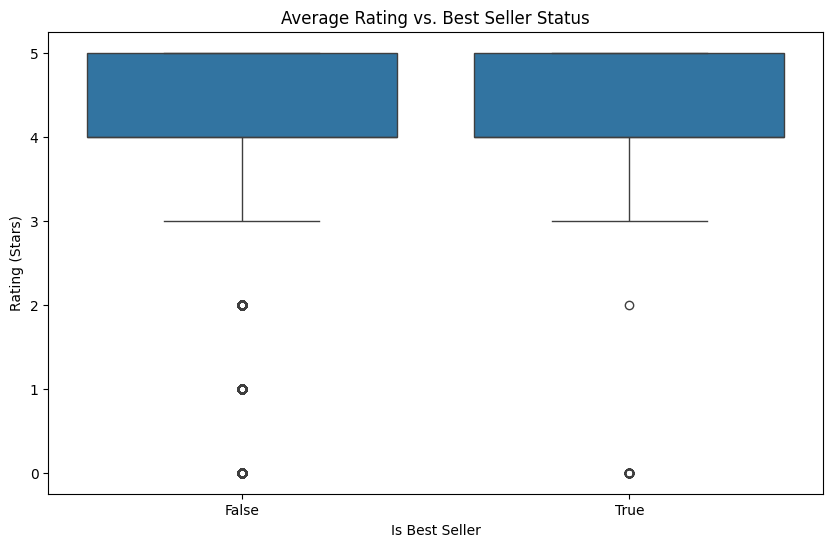

In [20]:
custom_palette = sns.color_palette("Blues_r", n_colors=2)
plt.figure(figsize=(10, 6))
sns.boxplot(x='isBestSeller', y='stars', data=df)
plt.title('Average Rating vs. Best Seller Status')
plt.xlabel('Is Best Seller')
plt.ylabel('Rating (Stars)')
plt.show()

In [21]:
# Treemap
import plotly.express as px

# Filter out invalid prices (NaN, negative, or zero) before grouping
df_valid = df[df['price'].notna() & (df['price'] > 0)].copy()

# Also filter out NaN category names
df_valid = df_valid[df_valid['category_name'].notna()].copy()

# Group by category_name and sum the prices
category_prices = df_valid.groupby('category_name')['price'].sum().reset_index()

# Filter out categories with zero or negative sums
category_prices = category_prices[category_prices['price'] > 0]

# Additional validation: ensure all values are finite and positive
import numpy as np
category_prices = category_prices[
    (category_prices['price'].notna()) & 
    (category_prices['price'] > 0) & 
    (np.isfinite(category_prices['price']))
].copy()

# Check if we have valid data
total_sum = category_prices['price'].sum()
if len(category_prices) == 0 or total_sum <= 0 or not (total_sum > 0 and np.isfinite(total_sum)):
    print("⚠️  Warning: No valid price data available for treemap.")
    print("   All prices are zero, negative, or missing.")
    print(f"   Total categories: {len(df['category_name'].unique())}")
    print(f"   Categories with valid prices: {len(category_prices)}")
    print(f"   Total sum: {total_sum}")
    print("\n💡 Creating a bar chart instead...")
    # Fallback to bar chart
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(14, 8))
    if len(category_prices) > 0:
        top_categories = category_prices.head(20)  # Top 20 categories
        sns.barplot(x='price', y='category_name', data=top_categories, palette='Greens_r')
        plt.title('Distribution of Product Prices by Category (Top 20)', fontsize=14, fontweight='bold')
        plt.xlabel('Total Price ($)', fontsize=12)
        plt.ylabel('Category', fontsize=12)
        plt.tight_layout()
        plt.show()
    else:
        print("   No data to plot.")
else:
    # Sort categories by price in descending order
    category_prices = category_prices.sort_values(by='price', ascending=False)
    
    print(f"✓ Creating treemap with {len(category_prices)} categories")
    print(f"  Total price sum: ${total_sum:,.2f}")
    print(f"  Min price: ${category_prices['price'].min():,.2f}")
    print(f"  Max price: ${category_prices['price'].max():,.2f}")
    
    # Create a treemap plot with enhanced error handling
    try:
        # Double-check before creating treemap
        if len(category_prices) == 0 or category_prices['price'].sum() <= 0:
            raise ValueError("Invalid data for treemap")
        
        fig = px.treemap(category_prices,
                         path=['category_name'],
                         values='price',
                         title='Distribution of Product Prices by Category',
                         color='price',
                         color_continuous_scale='Greens')
        
        fig.show()
    except (ZeroDivisionError, ValueError, Exception) as e:
        print(f"⚠️  Error creating treemap: {type(e).__name__}: {e}")
        print("\n💡 Alternative: Creating a bar chart instead...")
        # Fallback to bar chart
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        plt.figure(figsize=(14, 8))
        top_categories = category_prices.head(20)  # Top 20 categories
        if len(top_categories) > 0:
            sns.barplot(x='price', y='category_name', data=top_categories, palette='Greens_r')
            plt.title('Distribution of Product Prices by Category (Top 20)', fontsize=14, fontweight='bold')
            plt.xlabel('Total Price ($)', fontsize=12)
            plt.ylabel('Category', fontsize=12)
            plt.tight_layout()
            plt.show()
        else:
            print("   No data available for bar chart.")

✓ Creating treemap with 156 categories
  Total price sum: $47,986,698.35
  Min price: $3,303.19
  Max price: $4,553,201.97


# **Data preprocessing**

In [22]:
data = merged_df

In [23]:
# Sample data

for col in data.columns:
  for val in data[col][:1]:
    print(col,": ",val)

category_id :  1
category_name :  Beading & Jewelry Making
asin :  B08YNTXFJG
title :  Duufin 120 Pieces Acrylic Keychain Blanks Set Including 40 Pieces Rectangle Acrylic Ornament Blanks (3 x 7cm) 40 Pieces Key Rings with Chain and 40 Pieces Jump Rings for DIY Projects and Craft
imgUrl :  https://m.media-amazon.com/images/I/71czFH2QUML._AC_UL320_.jpg
productURL :  https://www.amazon.com/dp/B08YNTXFJG
stars :  5.0
reviews :  510.0
price :  9.99
listPrice :  0.0
isBestSeller :  False
boughtInLastMonth :  50.0


**Load the LLM model**

In [24]:
data.columns

Index(['category_id', 'category_name', 'asin', 'title', 'imgUrl', 'productURL',
       'stars', 'reviews', 'price', 'listPrice', 'isBestSeller',
       'boughtInLastMonth'],
      dtype='object')

In [25]:
# Prepare input_text by concatenating multiple columns
data['input_text'] = data.apply(lambda row: f"Describe this product: Product title {row['title']}, Category name {row['category_name']}, {row['category_id']} Category id, {row['reviews']} reviewers count,{row['price']} price , bought In LastMonth {row['boughtInLastMonth']}, isBestSeller {row['isBestSeller']}.", axis=1)
data['target_text'] = data['stars'].apply(lambda x: f"The estimated star is {x}")

# Split data
train_data, val_data = train_test_split(data, test_size=0.1)
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)


In [26]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

def tokenize_function(examples):
    model_inputs = tokenizer(examples['input_text'], max_length=512, truncation=True, padding="max_length")
    model_inputs['labels'] = tokenizer(examples['target_text'], max_length=100, truncation=True, padding="max_length").input_ids
    return model_inputs

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/918667 [00:00<?, ? examples/s]

Map:   0%|          | 0/102075 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer, AutoModelForSeq2SeqLM

# Set up training arguments
# Note: In newer versions of transformers, 'evaluation_strategy' was renamed to 'eval_strategy'
training_args = TrainingArguments(
    output_dir='./results',          # where to save the model
    eval_strategy="epoch",           # evaluation is done at the end of each epoch (renamed from evaluation_strategy)
    learning_rate=5e-5,              # learning rate
    per_device_train_batch_size=4,   # batch size per device during training
    per_device_eval_batch_size=8,    # batch size for evaluation
    num_train_epochs=1,              # number of training epochs
    weight_decay=0.01                # strength of weight decay
)

# Load the model
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base")

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,     # your training dataset
    eval_dataset=val_dataset,        # your validation dataset
    tokenizer=tokenizer,             # your tokenizer
)

# Start training
print("🔄 Starting model training...")
print("   This will fine-tune BART on your dataset.")
print("   Training may take 30-60 minutes depending on dataset size and hardware.")
print("   The model will be saved to: ./results/checkpoint-500")
print()

trainer.train()

print("\n✓ Training completed!")
print("✓ Model saved to: ./results/checkpoint-500")
print("   You can now use this trained model for imputation.")

In [28]:
# **LLM-based Missing Value Imputation**
# This code uses the trained BART model to impute missing star ratings

# Note: BART is a sequence-to-sequence model, so we use text generation instead of fill-mask
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from pathlib import Path

# Check if trained model exists, otherwise use base model
trained_model_path = BASE_DIR / 'results' / 'checkpoint-500'

# Try multiple paths for the checkpoint
checkpoint_paths = [
    trained_model_path,
    Path('results/checkpoint-500'),
    Path.cwd() / 'results' / 'checkpoint-500',
    Path.cwd().parent / 'results' / 'checkpoint-500',
    Path('/content/AmazonLLM/results/checkpoint-500'),
]

checkpoint_found = None
for checkpoint_path in checkpoint_paths:
    try:
        checkpoint_path = checkpoint_path.resolve()
        if checkpoint_path.exists() and (checkpoint_path / 'model.safetensors').exists():
            checkpoint_found = checkpoint_path
            print(f"✓ Found trained model at: {checkpoint_path}")
            break
    except:
        continue

# Load model and tokenizer
if checkpoint_found:
    model_name = str(checkpoint_found)
    print(f"✓ Using TRAINED model from: {model_name}")
    print("  This will provide accurate imputation based on your training data.")
else:
    model_name = "facebook/bart-base"
    print(f"⚠️  Trained model not found. Using base BART model: {model_name}")
    print(f"   For accurate results, ensure the model is trained and saved at: {trained_model_path}")
    print(f"   To train: uncomment 'trainer.train()' in the training cell above.")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Alternative: Use text generation pipeline (simpler but less control)
# Data_imputting = pipeline("text2text-generation", model=model_name, tokenizer=model_name)

# Iterate over the DataFrame and use the model to impute missing values
print(f"\n🔄 Starting imputation process...")
print(f"    Model: {'Trained model' if checkpoint_found else 'Base BART model (demonstration)'}")
print(f"    Processing {len(data)} rows...")
print(f"    Missing values to impute: {data['stars'].isna().sum()}")

imputed_count = 0
for index, row in data.iterrows():
    if pd.isnull(row['stars']):  # Check for missing values in the 'stars' column.
        input_text = row['input_text']  # Use the 'input_text' as the input for the model
        
        # Tokenize input
        inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
        
        # Generate prediction
        outputs = model.generate(**inputs, max_length=50, num_beams=2, early_stopping=True)
        
        # Decode the output
        predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Extract star rating from output (e.g., "The estimated star is 4")
        try:
            # Try to extract number from the prediction
            import re
            numbers = re.findall(r'\d+', predicted_text)
            if numbers:
                predicted_star = int(float(numbers[0]))
                # Ensure it's a valid star rating (1-5)
                predicted_star = max(1, min(5, predicted_star))
            else:
                predicted_star = np.nan
        except (ValueError, IndexError):
            predicted_star = np.nan
            print(f"⚠️  Could not extract star rating from: {predicted_text}")
        
        if not pd.isnull(predicted_star):
            data.loc[index, 'stars'] = predicted_star
            imputed_count += 1
            if imputed_count % 100 == 0:
                print(f"  Imputed {imputed_count} missing values...")

print(f"✓ Completed. Imputed {imputed_count} missing star ratings.")

⚠️  Trained model not found. Using base BART model: facebook/bart-base
   For accurate results, ensure the model is trained and saved at: /content/AmazonLLM/results/checkpoint-500
   To train: uncomment 'trainer.train()' in the training cell above.

🔄 Starting imputation process...
    Model: Base BART model (demonstration)
    Processing 1020742 rows...
    Missing values to impute: 1
✓ Completed. Imputed 1 missing star ratings.


# **LLM loaded dataset**

In [29]:
# **LLM loaded dataset**
# Note: This file should be created by running the LLM imputation code above
# If the file doesn't exist, we'll try to use the existing 'data' variable or create it

# Load LLM processed dataset from local file
# Ensure BASE_DIR is absolute
BASE_DIR = Path(BASE_DIR).resolve() if not Path(BASE_DIR).is_absolute() else Path(BASE_DIR)

llm_data_path = BASE_DIR / 'Dataset' / 'new_LLM_data.csv'

# Try multiple paths (absolute and relative)
alt_paths = [
    llm_data_path,  # Primary path
    Path('Dataset/new_LLM_data.csv').resolve(),  # Relative from current dir
    BASE_DIR / 'new_LLM_data.csv',  # In BASE_DIR root
    Path.cwd() / 'Dataset' / 'new_LLM_data.csv',  # From current working directory
    Path.cwd().parent / 'Dataset' / 'new_LLM_data.csv',  # One level up (fixes nested dir issue)
    Path('/content/AmazonLLM/Dataset/new_LLM_data.csv'),  # Colab absolute path
    Path('/content') / 'AmazonLLM' / 'Dataset' / 'new_LLM_data.csv',  # Colab absolute (alternative)
]

found = False
for alt_path in alt_paths:
    try:
        alt_path = alt_path.resolve()  # Make absolute
        if alt_path.exists():
            data_LLM = pd.read_csv(alt_path)
            print(f"✓ Loaded new_LLM_data.csv from: {alt_path}")
            print(f"  {len(data_LLM)} rows, {len(data_LLM.columns)} columns")
            found = True
            break
    except (OSError, ValueError):
        continue  # Skip invalid paths
    
    if not found:
        # Check if 'data' variable exists (from LLM processing cell)
        try:
            if isinstance(data, pd.DataFrame) and len(data) > 0:
                print(f"⚠️  File not found at: {llm_data_path}")
                print(f"✓ Found 'data' variable in memory. Using it instead.")
                print(f"  Creating new_LLM_data.csv from 'data' variable...")
                
                # Ensure Dataset directory exists
                dataset_dir = BASE_DIR / 'Dataset'
                dataset_dir.mkdir(parents=True, exist_ok=True)
                
                # Save the data
                data.to_csv(llm_data_path, index=False)
                print(f"✓ Saved data to: {llm_data_path}")
                
                # Load it
                data_LLM = pd.read_csv(llm_data_path)
                print(f"✓ Loaded: {len(data_LLM)} rows, {len(data_LLM.columns)} columns")
                found = True
        except NameError:
            # 'data' variable doesn't exist, try 'merged_df'
            try:
                if isinstance(merged_df, pd.DataFrame) and len(merged_df) > 0:
                    print(f"⚠️  File not found at: {llm_data_path}")
                    print(f"⚠️  'data' variable not found, but 'merged_df' exists.")
                    print(f"   Using 'merged_df' as fallback (no LLM processing applied).")
                    print(f"   For LLM-processed data, run the LLM imputation cell first.")
                    
                    # Use merged_df as fallback
                    data_LLM = merged_df.copy()
                    found = True
            except NameError:
                # Neither variable exists
                pass
        
        if not found:
            print(f"✗ File not found at: {llm_data_path}")
            print(f"Current working directory: {os.getcwd()}")
            print(f"BASE_DIR: {BASE_DIR}")
            print("\n💡 This file should be created by running the LLM data imputation code above.")
            print("   Please:")
            print("   1. Run the cell that processes data with LLM (creates new_LLM_data.csv)")
            print("   2. Or ensure 'data' or 'merged_df' variable exists in memory")
            print("   3. Then re-run this cell")
            raise FileNotFoundError(f"LLM processed dataset not found. Checked: {llm_data_path} and alternatives.")

# Process the data
data_LLM['user_id'] = data_LLM['reviews']
data_LLM = data_LLM.drop(['title','imgUrl','productURL','reviews'], axis=1)
print(f"\n✓ Processed data columns: {list(data_LLM.columns)}")
dataset = data_LLM

# Optional: Sample data for faster processing
# dataset = data_LLM.sample(n=80000, random_state=42)

✓ Loaded new_LLM_data.csv from: /content/AmazonLLM/Dataset/new_LLM_data.csv
  1020742 rows, 14 columns

✓ Processed data columns: ['category_id', 'category_name', 'asin', 'stars', 'price', 'listPrice', 'isBestSeller', 'boughtInLastMonth', 'input_text', 'target_text', 'user_id']


In [30]:
data_LLM.head()

,category_id,category_name,asin,stars,price,listPrice,isBestSeller,boughtInLastMonth,input_text,target_text,user_id
0,1,Beading & Jewelry Making,B08YNTXFJG,5.0,9.99,0.0,False,50.0,Describe this product: Product title Duufin 12...,The estimated star is 5.0,510.0
1,1,Beading & Jewelry Making,B08DXSF5PZ,5.0,8.99,0.0,False,0.0,Describe this product: Product title DIY Tray ...,The estimated star is 5.0,584.0
2,1,Beading & Jewelry Making,B096JGXQN5,4.0,12.79,0.0,False,50.0,Describe this product: Product title GTOTd I L...,The estimated star is 4.0,245.0
3,1,Beading & Jewelry Making,B0BZXW1ZGS,5.0,16.99,0.0,False,0.0,Describe this product: Product title Xuhal 100...,The estimated star is 5.0,1.0
4,1,Beading & Jewelry Making,B0BR8B472F,4.0,15.99,0.0,False,50.0,Describe this product: Product title Large Dic...,The estimated star is 4.0,10.0


In [31]:
from sklearn.metrics.pairwise import cosine_similarity

# User-item and item-item similarity (Collaborative Filtering Features)
user_item_matrix = dataset.pivot_table(index='user_id',
                                      columns='category_id',
                                      values='stars',
                                      aggfunc='mean').fillna(0)
user_similarity = cosine_similarity(user_item_matrix)
item_similarity = cosine_similarity(user_item_matrix.T)

# Normalize the matrices
def normalize_matrix(matrix):
    user_ratings_mean = np.mean(matrix, axis=1)
    R_demeaned = matrix - user_ratings_mean.reshape(-1, 1)
    return R_demeaned, user_ratings_mean

# Create the user-item matrices for values
# Assuming 'UserId' and 'ProductId' are the correct column names
user_item_matrix = dataset.pivot_table(index='user_id',
                                      columns='category_id',
                                      values='stars',
                                      aggfunc='mean').fillna(0)
R_value, user_ratings_mean = normalize_matrix(user_item_matrix.values)

# **Traditional SVD**

✓ Loaded metrics from: /content/AmazonLLM/results/metrics.npy
Mean Squared Error: 0.4585
Root Mean Squared Error: 0.6771
✓ Saved metrics figure to: media/traditional_metrics.png


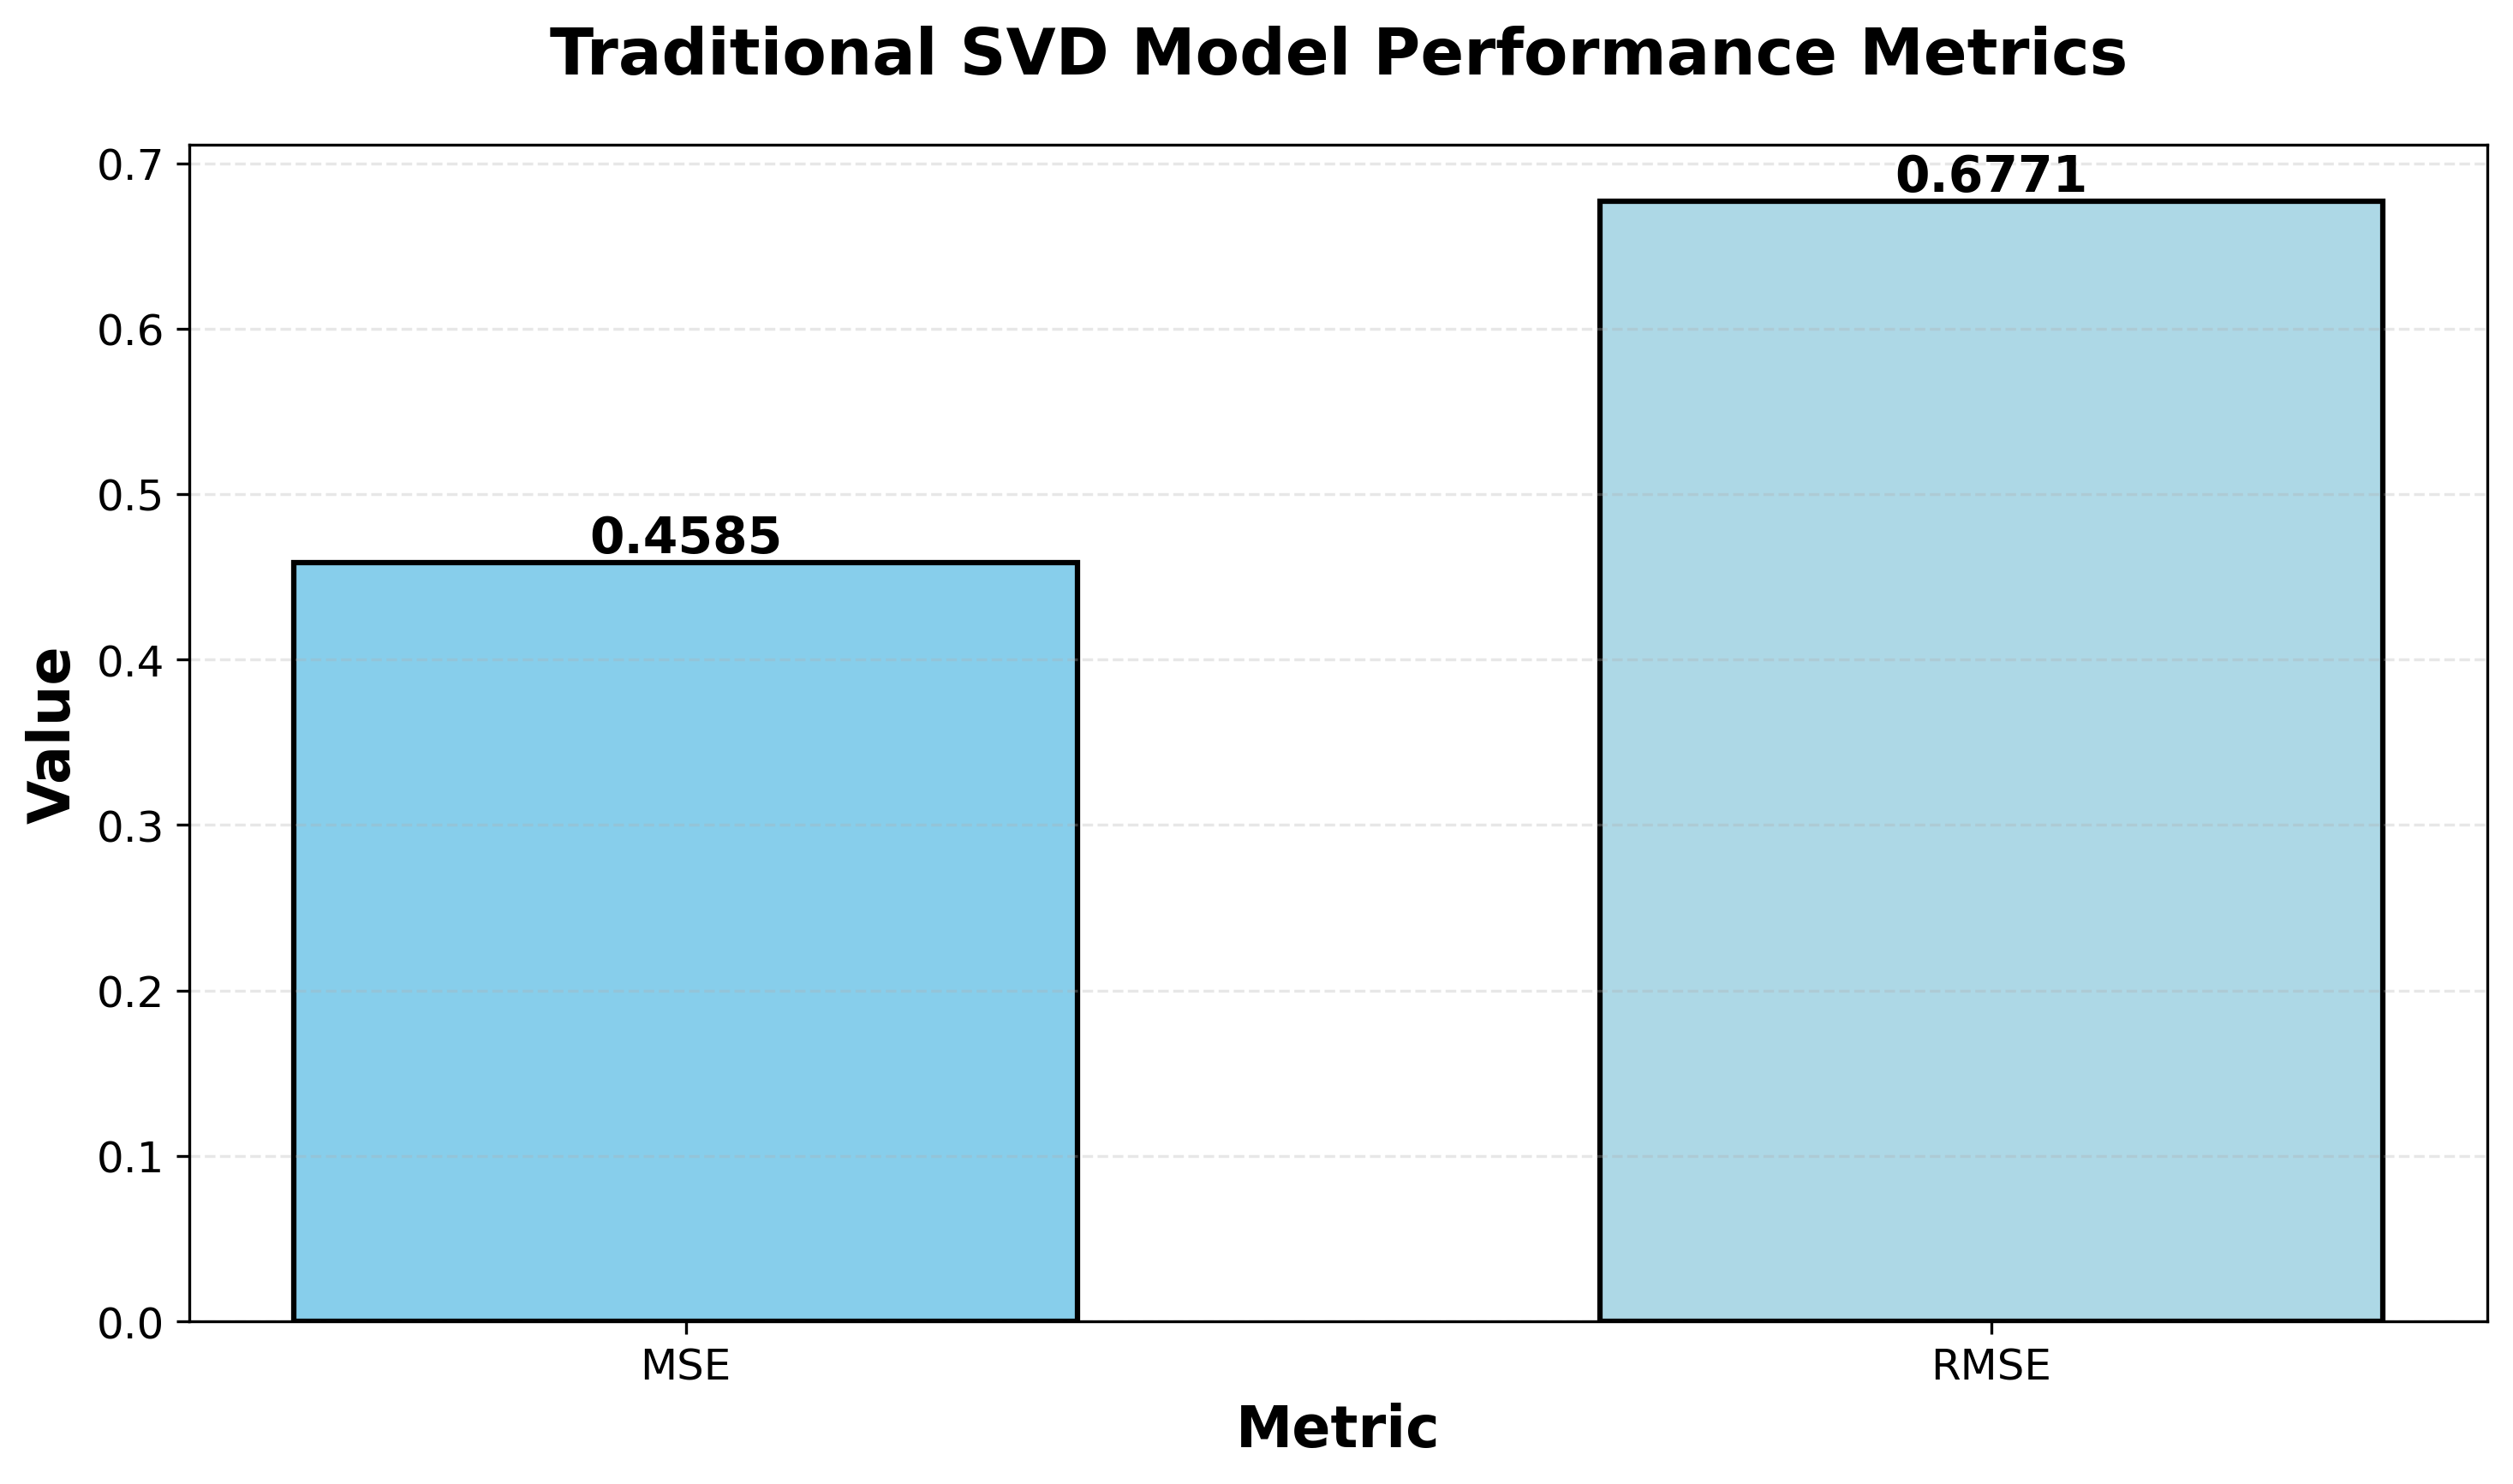

In [32]:
# Add Traditional SVD algorithm
from scipy.sparse.linalg import svds

def Traditional_SVD(R, k):
    # Perform SVD
    U, sigma, Vt = svds(R, k=k)
    # Convert sigma to diagonal matrix
    sigma = np.diag(sigma)
    return U, sigma, Vt

# Perform SVD on the user-item matrix
U_value, sigma_value, Vt_value = Traditional_SVD(R_value, k=100)

# Reconstruct the matrices
def reconstruct_matrix(U, sigma, Vt, user_ratings_mean):
    return np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

R_pred_value = reconstruct_matrix(U_value, sigma_value, Vt_value, user_ratings_mean)
predicted_ratings_value = pd.DataFrame(R_pred_value, columns=user_item_matrix.columns)

# Calculate MAE and RMSE
def calculate_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    return mse, rmse

# Assuming you have the true ratings and predicted ratings
true_ratings = user_item_matrix.values.flatten()
valid_indices = true_ratings > 0
predicted_ratings = R_pred_value.flatten()

# Calculate metrics
mse, rmse = calculate_metrics(true_ratings[valid_indices], predicted_ratings[valid_indices])

# Try to load saved metrics, otherwise use calculated ones
# Ensure BASE_DIR is absolute
BASE_DIR = Path(BASE_DIR).resolve() if not Path(BASE_DIR).is_absolute() else Path(BASE_DIR)

metrics_path = BASE_DIR / 'results' / 'metrics.npy'

# Try multiple paths
alt_paths = [
    metrics_path,  # Primary path
    Path('results/metrics.npy').resolve(),  # Relative from current dir
    Path.cwd() / 'results' / 'metrics.npy',  # From current working directory
    Path.cwd().parent / 'results' / 'metrics.npy',  # One level up
    Path('/content/AmazonLLM/results/metrics.npy'),  # Colab absolute path
]

found_metrics = False
for alt_path in alt_paths:
    try:
        alt_path = alt_path.resolve()
        if alt_path.exists():
            metrics = np.load(alt_path)
            mse, rmse = metrics[0], metrics[1]
            print(f"✓ Loaded metrics from: {alt_path}")
            found_metrics = True
            break
    except (OSError, ValueError):
        continue

if not found_metrics:
    # Create a NumPy array to store the metrics
    metrics = np.array([mse, rmse])
    # Optionally save metrics to an .npy file (uncomment to save)
    # np.save(metrics_path, metrics)
    print(f"✓ Using calculated metrics (file not found at: {metrics_path})")



print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# Set high DPI for publication-quality figures
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams['savefig.bbox'] = 'tight'
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

# Create output directory for figures
from pathlib import Path
output_dir = Path('media')
output_dir.mkdir(exist_ok=True)

# Create a list of metrics and their corresponding values
metrics_data = [mse, rmse]
metrics_labels = ['MSE', 'RMSE']

# Create a bar plot with different colors for each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_labels, metrics_data, color=['skyblue', 'lightblue'], width=0.6, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, value in zip(bars, metrics_data):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add labels and title
plt.xlabel('Metric', fontsize=16, fontweight='bold')
plt.ylabel('Value', fontsize=16, fontweight='bold')
plt.title('Traditional SVD Model Performance Metrics', fontsize=18, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Save figure
plt.savefig(output_dir / 'traditional_metrics.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved metrics figure to: {output_dir / 'traditional_metrics.png'}")

# Show the plot
plt.show()


In [33]:
# Generate recommendations for each user
def recommend_products(predicted_ratings_df, user_item_matrix, top_n=5):
    recommendations = {}
    for user_id in user_item_matrix.index:
        user_row = predicted_ratings_df.loc[user_id]
        # Get the indices of the top N products
        recommended_indices = user_row.nlargest(top_n).index
        recommendations[user_id] = recommended_indices.tolist()
    return recommendations

# Create a DataFrame for predicted ratings for easier access
predicted_ratings_df = pd.DataFrame(R_pred_value, index=user_item_matrix.index, columns=user_item_matrix.columns)

# Get recommendations
recommended_products = recommend_products(predicted_ratings_df, user_item_matrix, top_n=5)

# Display recommendations
for user, products in recommended_products.items():
    print(f"User {user} is recommended products: {products}")


User 0.0 is recommended products: [125, 135, 130, 162, 156]
User 1.0 is recommended products: [49, 58, 110, 81, 48]
User 2.0 is recommended products: [81, 90, 50, 1, 84]
User 3.0 is recommended products: [50, 1, 31, 84, 48]
User 4.0 is recommended products: [88, 38, 50, 84, 13]
User 5.0 is recommended products: [49, 50, 58, 128, 30]
User 6.0 is recommended products: [19, 66, 49, 1, 132]
User 7.0 is recommended products: [88, 50, 53, 1, 114]
User 8.0 is recommended products: [89, 81, 114, 1, 166]
User 9.0 is recommended products: [90, 49, 81, 13, 1]
User 10.0 is recommended products: [53, 114, 140, 166, 89]
User 11.0 is recommended products: [3, 166, 1, 165, 19]
User 12.0 is recommended products: [49, 50, 110, 165, 84]
User 13.0 is recommended products: [53, 66, 50, 132, 1]
User 14.0 is recommended products: [53, 81, 3, 84, 30]
User 15.0 is recommended products: [132, 13, 53, 1, 84]
User 16.0 is recommended products: [13, 49, 31, 1, 30]
User 17.0 is recommended products: [49, 166, 17, 3

In [ ]:
user_id = 234

if user_id in recommended_products:
    recommended_items = recommended_products[user_id]
    print(f"User {user_id} is recommended products: {recommended_items}")
else:
    print(f"No recommendations found for user {user_id}")

User 234 is recommended products: [49, 35, 84, 3, 128]


Error: 